# Device grouping

In [2]:
%pip install spacy spacy-transformers
%pip install fuzzywuzzy
%pip install python-Levenshtein

!python -m spacy download en_core_web_lg

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
2023-09-05 07:36:01.962927: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 4.8 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [81]:
import spacy
import pandas as pd
from tqdm import tqdm
import numpy as np
import os
from fuzzywuzzy import fuzz
from collections import defaultdict

In [75]:


# Load spaCy model
nlp = spacy.load('en_core_web_lg')


# Convert list of appliances to a list of spaCy objects and filter out those without vectors
appliances_nlp = [(i, nlp(appliance)) for i, appliance in enumerate(appliances) if nlp(appliance).has_vector]

# Create a similarity matrix
similarity_matrix = np.zeros((len(appliances_nlp), len(appliances_nlp)))

for idx1 in tqdm(range(len(appliances_nlp))):
    for idx2 in range(len(appliances_nlp)):
        if idx2 > idx1:  # Compute only upper triangle
            similarity_matrix[idx1, idx2] = appliances_nlp[idx1][1].similarity(appliances_nlp[idx2][1])

# Make the matrix symmetric
similarity_matrix = similarity_matrix + similarity_matrix.T - np.diag(similarity_matrix.diagonal())
# works pretty well with 0.8
threshold = 0.9
grouped_appliances = {}
visited = set()

for idx1, (i, appliance) in enumerate(appliances_nlp):
    if i in visited:
        continue

    # Find indices of appliances that are similar to the current appliance
    similar_indices = np.where(similarity_matrix[idx1] > threshold)[0]

    # Group those appliances together
    grouped_appliances[appliance] = [appliances[appliances_nlp[idx][0]] for idx in similar_indices]

    # Mark the similar appliances as visited
    visited.update([appliances_nlp[idx][0] for idx in similar_indices])



100%|██████████| 691/691 [00:00<00:00, 880.27it/s]


In [80]:
for appliance in grouped_appliances:
    grouped_appliances[appliance] = set(grouped_appliances[appliance])


# print this to file
with open('./Energy_graph/device_grouping.txt', 'w') as f:
    for appliance in grouped_appliances:
        f.write(f'{appliance}: {grouped_appliances[appliance]}\n')
grouped_appliances

{circulation pump: {'circulation pump'},
 dishwasher: {'dishwasher'},
 freezer: {'freezer', 'fridge freezer'},
 washing machine: {'washing machine', 'washing machine microwave breadmaker'},
 ev: set(),
 heat pump: {'heat pump'},
 fridge: {'fridge', 'fridge freezer'},
 air conditioner: {'air conditioner',
  'air conditioning',
  'air exchanger',
  'air exhaust'},
 pc: {'pc'},
 clothes iron: set(),
 tv: {'primary tv', 'tv', 'tv dvd digibox lamp'},
 wet appliance: set(),
 motor: set(),
 iron: {'iron', 'soldering iron'},
 router: {'adsl router', 'router'},
 lamp: {'lamp', 'utilityrm lamp'},
 monitor: {'monitor'},
 hair dryer: {'hair dryer'},
 heater: {'electric heater'},
 radio: set(),
 coffee machine: {'coffee machine'},
 electric hob: set(),
 core2 server: {'server', 'server hdd'},
 treadmill: {'treadmill'},
 oven: {'oven'},
 steam iron: set(),
 toaster: {'toaster'},
 24 inch lcd bedroom: {'24 inch lcd'},
 network attached storage: set(),
 stereo speakers bedroom: set(),
 microwave: {'mi

# Class balances

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import spacy
from collections import defaultdict
import os
from tqdm import tqdm
import numpy as np

In [ ]:
data = pd.read_pickle("./Energy_graph/data/processed/labelled/REDD.pkl")


data["REDD_1"]

In [17]:
df = pd.DataFrame()
for d,v in tqdm(data["REDD_1"].items()):
    v.columns = [d]
    df = pd.concat([df,v ], axis=1)

df.fillna(0, inplace=True)
df[df>0] = 1 
df[df<=0] = 0

100%|██████████| 10/10 [00:00<00:00, 50.89it/s]


In [14]:
# set the threshold to 0.0001
threshold = 0.0001
time_window = "6H"

cumulative_appearances = pd.Series(dtype='float64')

for house in data:
    df = pd.DataFrame()
    for device in data[house]:
        if device == 'aggregate':
            continue
        df = pd.concat([df, data[house][device]], axis=1)
    df[df > threshold] = 1
    df[df <= threshold] = 0
    
    # Resample the DataFrame to 6-hour windows and sum the values
    resampled_df = df.resample(time_window).sum()

    # Check the appearance of each device in the windows
    appearances = (resampled_df > 0).sum()
    
    # Aggregate the appearances for the same devices across houses
    cumulative_appearances = cumulative_appearances.add(appearances, fill_value=0)


In [16]:
cumulative_appearances

 bread-maker                    319.0
 chest freezer                 2266.0
 chest freezer (in garage)     2046.0
 combination microwave         1359.0
 computer                      2014.0
 computer site                11118.0
 dehumidifier/heater            513.0
 desktop computer              1677.0
 dishwasher                    7890.0
 dryer                          745.0
 electric heater               2344.0
 electric heater (1)?            67.0
 electric heater (2)            717.0
 food mixer                      24.0
 freezer                       9207.0
 freezer (garage)              3922.0
 freezer (utility room)        1980.0
 freezer(garage)               1676.0
 fridge                       11341.0
 fridge & freezer              1772.0
 fridge(garage)                1646.0
 fridge-freezer               23421.0
 fridge-freezer (1)            1916.0
 fridge-freezer (2)            1584.0
 hi-fi                         3257.0
 kenwood kmix                   183.0
 kettle     

In [24]:

# Load spaCy model
nlp = spacy.load('en_core_web_trf')

# Preprocess device names
def preprocess_device_name(device_name):
    return ''.join([char for char in device_name if char.isalpha() or char.isspace()]).strip()

# Create a mapping from original device name to its processed form and spaCy tokens
processed_names = {name: preprocess_device_name(name) for name in cumulative_appearances.index}
processed_tokens = {name: nlp(processed_name) for name, processed_name in processed_names.items()}

# Group devices using spaCy similarity
threshold = 0.6
grouped_values = defaultdict(float)

for original_name, value in cumulative_appearances.items():
    processed_name = processed_names[original_name]
    processed_token = processed_tokens[original_name]

    added = False
    for grouped_name, grouped_token in processed_tokens.items():
        if processed_token.similarity(grouped_token) > threshold:
            grouped_values[grouped_name] += value
            added = True
            break

    if not added:
        grouped_values[processed_name] += value
        processed_tokens[original_name] = processed_token

# Convert the defaultdict back to a pandas series
grouped_series = pd.Series(grouped_values)


/tmp/ipykernel_1155/3799702240.py:22: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  if processed_token.similarity(grouped_token) > threshold:
/tmp/ipykernel_1155/3799702240.py:22: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  if processed_token.similarity(grouped_token) > threshold:


plot the data

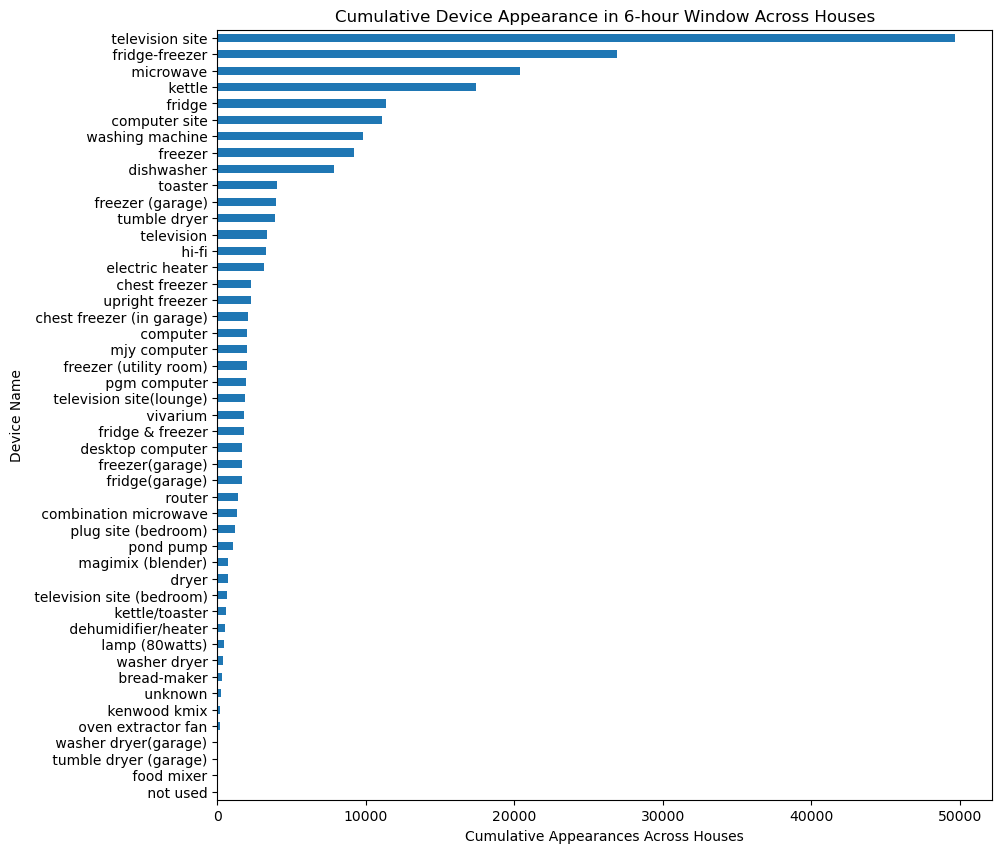

In [25]:

# Now, plot the aggregated appearances for all houses
grouped_series.sort_values().plot(kind='barh', figsize=(10, 10))
plt.xlabel('Cumulative Appearances Across Houses')
plt.ylabel('Device Name')
plt.title('Cumulative Device Appearance in 6-hour Window Across Houses')
plt.show()







# All the datasets class balances

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import spacy
from collections import defaultdict
import os
from tqdm import tqdm
import numpy as np
from functools import reduce
from fuzzywuzzy import fuzz
import re

def preprocess_string(string : str) -> str:
    string = string.lower().strip()
    string = re.sub(' +', ' ', string)
    string = string.replace("_", " ")
    string = string.replace("-", " ")
    string = string.replace("&", " ")
    string = string.split("(")[0]
    string = string.split("#")[0]

    string = string.strip()

    # handle known synoynms
    synonyms = {
        "refrigerator": "fridge",
        "vaccumcleaner": "vacuum cleaner",
        "breadmaker": "bread maker",
      
        
    }
    if string in synonyms:
        string = synonyms[string]

    if 'hi fi' in string:
        string = "audio system"

    if "router" in string:
        string = "router"

    if "treadmill" in string:
        string = "running machine"
        

    if "laptop" in string:
        string = "laptop"
    
    if "server" in string:
        string = "server"

    if "monitor" in string and not "baby" in string:
        string = "monitor"
    # special cases
    if "computer" in string and "charger" not in string:
        string = "pc"

    if "tv" in string:
        string = "television"

    if "television" in string:
        string = "television"

    if "macbook" in string:
        string = "laptop"
        
    if "car charger" == string:
        string = "ev"
    
    if "toast" in string:
        string = "toaster"
    
    if "modem" in string:
        string = "router"

    # we treat all audio devices as speakers so subwoofer is also a speaker
    if "subwoofer" in string:
        string = "speaker"

    if "speaker" in string:
        string = "speaker"

    if "iron" in string and "soldering" not in string:
        string = "iron"

    
    if "coffeemachine" in string:
        string = "coffee machine"
    if "coffee maker" in string:
        string = "coffee machine"

    if "dishwasher" in string:
        string = "dish washer"
    if "air conditioner" in string:
        string = "ac"

    if "air conditioning" in string:
        string = "ac"
    
    string = re.sub(' +', ' ', string)
    string = re.sub(r'\d+', '', string)
    return string.strip()

def create_mapping(labels : set):
    
    # preprocess the strings
    labels = [preprocess_string(a) for a in labels]
    # remove duplicates
    labels = list(set(labels))

    grouped_labels = {}
    threshold = 80  # Set a threshold for similarity

    for label in labels:
        found = False
        for key in grouped_labels:
            if fuzz.ratio(label.lower(), key.lower()) > threshold:
                grouped_labels[key].append(label)
                found = True
                break
        if not found:
            grouped_labels[label] = [label]


    # remove duplicates
    for key, value in grouped_labels.items():
        grouped_labels[key] = list(set(value))

    # create mapping where each value maps to its key
    mapping = {
        # "refrigerator" : "fridge" ,
    }
    for key, value in grouped_labels.items():
        for v in value:
            mapping[v] = str(key)
    
    mapping["fridge"] = "refrigerator"

    return mapping


# convert the data into a dataframe with the devices as columns
def process_dict(data : dict):
    threshold = 4.4e-5
    time_window = '6H'
    # devices to ignore
    ignore_list = [
    'CE appliance'
    ' kettle/toaster',
    ' dehumidifier/heater',
    'HairDryer-Straightener',
    'Office Desk',
    'heat basement',
    'set top box',
    'subpanel'
    ]   
    
    cumulative_appearances = pd.Series(dtype='float64')
    df = pd.DataFrame()
    dfs = []
    for device in data[house]:
        device_processed = preprocess_string(device)
        # skip aggregate as we are only interested in the individual devices
        if device_processed == 'aggregate':
            if len(data[house].keys()) == 1:
                return None
            continue
        
        if device == "aggregate" or "outlet" in device or "sockets" in device or "lamp" in device or "light" in device or "plug" in device or "appliance" in device:
                # print("2 IGNORED: ", house, device)
                continue
        skip = False
        for d in ignore_list:
            if d.strip().lower() in device.strip().lower():
                skip = True
                break
        if skip:
            print("2 IGNORED: ", house, device)
            continue

        curr_df = data[house][device]
        # print("COLUMNS: ", curr_df.columns, "DEVICE: ", device)
        curr_df.columns = [device_processed]


        # check if the index is unique
        # if not curr_df.index.is_unique:
        #     print("CURR_DF")
        #     print("INDEX NOT UNIQUE: ", device, "HOUSE: ", house)
        #     curr_df = curr_df[~curr_df.index.duplicated(keep='first')]

        # if not df.index.is_unique:
        #     print("DF")
        #     print("INDEX NOT UNIQUE: ", device, "HOUSE: ", house)
        #     df = df[~df.index.duplicated(keep='first')]
        dfs.append(curr_df)

    df = pd.concat(dfs, axis=1)
    df.fillna(0, inplace=True)
    # resample to 1 hour so we can use the same treshold for all datasets
    df = df.resample('8s').sum()
    df[df > threshold] = 1
    df[df <= threshold] = 0
    
    # Resample the DataFrame to 6-hour windows and sum the values
    resampled_df = df.resample(time_window).sum()

    # Check the appearance of each device in the windows
    appearances = (resampled_df > 0).sum()
    
    

    # Aggregate the appearances for the same devices across houses
    cumulative_appearances = cumulative_appearances.add(appearances, fill_value=0)
    
    
    return cumulative_appearances 

def get_device_names(data : dict):
    devices = []
    for house in data:
        for device in data[house]:
            if device == 'aggregate':
                continue
            if "outlet" in device:
                continue
            devices.append(device)

    return devices


2023-09-05 07:36:30.523043: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
path = "./Energy_graph/data/training_data/"
# path = "./Energy_graph/data/processed_new/"
devices = set()
appearances = []
print_house = False
for dataset in tqdm(os.listdir(path)):
    # skip dataset without devices
    # if "HUE" in dataset or "LERTA" in dataset or "UCIML" in dataset or "UK-DALE" in dataset:
    #     continue
    # for debugging
    # if "DRED" in dataset or "DEDDIAG" in dataset or "IAWE" in dataset or "IDEAL" in dataset or "ECO" in dataset or "SUST2" in dataset or "UK-DALE" in dataset or "ENERTALK" in dataset:
    #     continue
    if not dataset.endswith(".pkl"):
        continue
    print(dataset)
    if "UK-DALE" in dataset:
        print_house = True
    # load dataset  
    data_dict = pd.read_pickle(path + dataset)
    devices.update(get_device_names(data_dict))
    for house in data_dict:
        if print_house:
            print(house)
        # print(house)
        # convert to dataframe
        data = process_dict(data_dict)
        if data is None:
            continue
        appearances.append(data)
    print_house = False 

    


  0%|          | 0/13 [00:00<?, ?it/s]

REDD.pkl


  8%|▊         | 1/13 [00:00<00:08,  1.38it/s]

ECO.pkl


 15%|█▌        | 2/13 [00:47<05:08, 28.02s/it]

REFIT.pkl


 23%|██▎       | 3/13 [01:22<05:08, 30.86s/it]

UK-DALE.pkl
UKDALE_5
UKDALE_2
UKDALE_1
UKDALE_3


 31%|███       | 4/13 [08:53<29:30, 196.76s/it]

SUST2.pkl


 38%|███▊      | 5/13 [09:10<17:36, 132.11s/it]

ENERTALK.pkl


 46%|████▌     | 6/13 [11:16<15:09, 129.91s/it]

DEKN.pkl


 54%|█████▍    | 7/13 [11:22<08:57, 89.61s/it] 

DEDDIAG.pkl


 62%|██████▏   | 8/13 [11:53<05:53, 70.67s/it]

HEART.pkl


 69%|██████▉   | 9/13 [11:55<03:16, 49.20s/it]

IAWE.pkl


 77%|███████▋  | 10/13 [11:57<01:44, 34.79s/it]

HES.pkl


 85%|████████▍ | 11/13 [11:58<00:48, 24.48s/it]

DRED.pkl


100%|██████████| 13/13 [11:59<00:00, 55.38s/it]


In [11]:
mapping = create_mapping(devices)
# save mapping to pickle
pd.to_pickle(mapping, "./Energy_graph/device_mapping.pkl")

import copy
appearances_copy = copy.deepcopy(appearances)

for h in appearances_copy:
    preprocessed_index = [preprocess_string(ix) for ix in h.index]
    h.index = preprocessed_index


for h in appearances_copy:
    new_index = [mapping[idx] if idx in mapping else idx for idx in h.index]
    h.index = new_index

for i, h in enumerate(appearances_copy):
    appearances_copy[i] = h.groupby(level=0).sum()

96


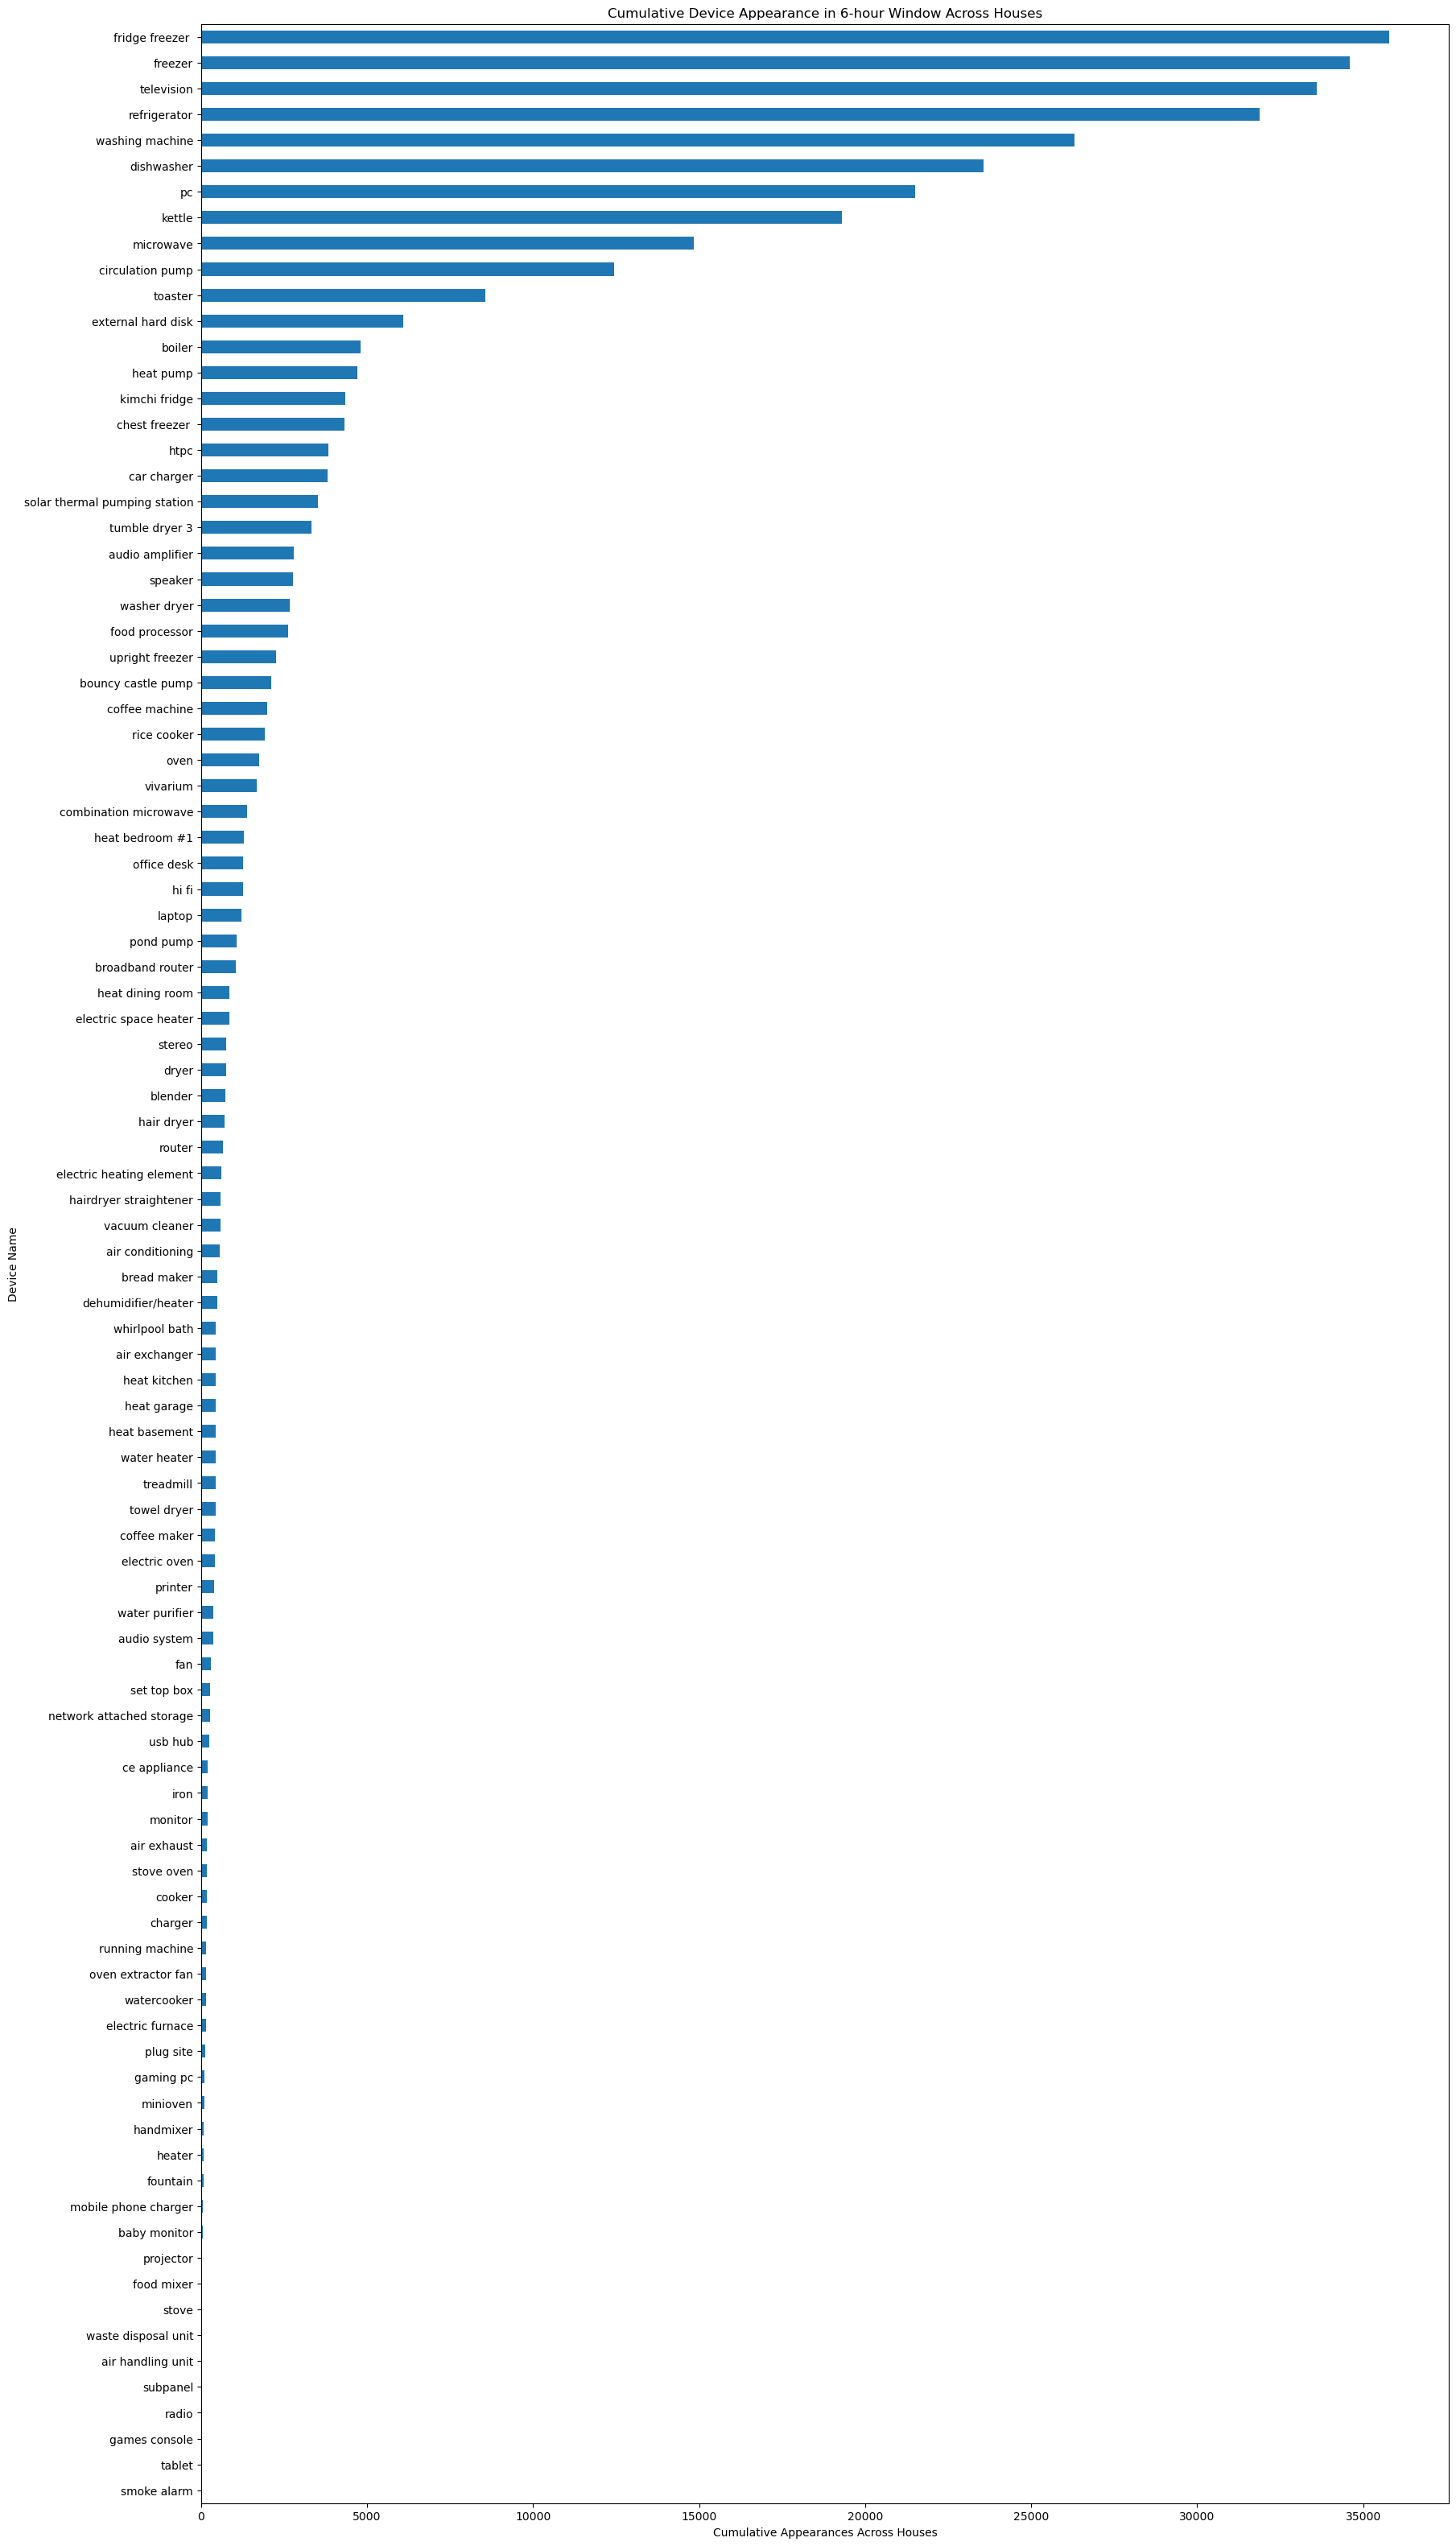

In [12]:
result = reduce(lambda x, y: x.add(y, fill_value=0), appearances_copy)
print(len(result))
result.sort_values().plot(kind='barh', figsize=(20, 40))
plt.xlabel('Cumulative Appearances Across Houses')
plt.ylabel('Device Name')
plt.title('Cumulative Device Appearance in 6-hour Window Across Houses')
plt.show()


In [10]:
import pickle
# save the result to pickle
with open('./Energy_graph/labeles.pkl', 'wb') as f:
    pickle.dump(list(result.index), f, pickle.HIGHEST_PROTOCOL)

# Cleaning labels

In [ ]:
import tqdm

In [14]:
labels = []

path = "./Energy_graph/data/processed/labelled/"
# path = "./Energy_graph/data/processed_new/"
devices = set()
appearances = []
print_house = False
for dataset in tqdm(os.listdir(path)):
    # skip dataset without devices
    if "HUE" in dataset or "LERTA" in dataset or "UCIML" in dataset:
        continue

    if not "UK-DALE" in dataset:
        continue
    # for debugging
    # if "DRED" in dataset or "DEDDIAG" in dataset or "IAWE" in dataset or "IDEAL" in dataset or "ECO" in dataset or "SUST2" in dataset or "ENERTALK" in dataset:
    #     continue
    if not dataset.endswith(".pkl"):
        continue
    # load dataset  
    data_dict = pd.read_pickle(path + dataset)
    # devices.update(get_device_names(data_dict))
    for house in data_dict:
        print("***************" + house)
        for device in data_dict[house]:
            print(device)


    


100%|██████████| 16/16 [00:03<00:00,  4.39it/s]

***************UKDALE_5
atom_pc
nespresso_pixie
electric_hob
core2_server
treadmill
oven
steam_iron
toaster
24_inch_lcd_bedroom
aggregate
network_attached_storage
stereo_speakers_bedroom
primary_tv
washer_dryer
microwave
kettle
home_theatre_amp
PS4
hairdryer
i7_desktop
24_inch_lcd
sky_hd_box
fridge_freezer
dishwasher
vacuum_cleaner
***************UKDALE_2
speakers
monitor
cooker
playstation
running_machine
laptop
server
laptop2
toaster
modem
microwave
washing_machine
router
aggregate
kettle
dish_washer
fridge
rice_cooker
server_hdd
***************UKDALE_1
hifi_office
dishwasher
aggregate
fridge
kitchen_lights
office_fan
livingroom_lamp_tv
iPad_charger
soldering_iron
kitchen_lamp2
coffee_machine
childs_table_lamp
bedroom_chargers
data_logger_pc
gigE_&_USBhub
livingroom_s_lamp2
subwoofer_livingroom
LED_printer
htpc
microwave
lcd_office
tv
gas_oven
childs_ds_lamp
hair_dryer
kitchen_radio
DAB_radio_livingroom
baby_monitor_tx
iron
utilityrm_lamp
office_lamp1
samsung_charger
lighting_circuit